## PRedItOR: Text Guided Image Editing with Diffusion Prior
https://arxiv.org/pdf/2302.07979.pdf

In [226]:
# !pip install -r requirements.txt

In [ ]:
# !sh download_weights.sh

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, einsum

import numpy as np
from dalle2_pytorch import DALLE2, DiffusionPriorNetwork, DiffusionPrior, OpenAIClipAdapter, train_configs
from dalle2_pytorch.tokenizer import tokenizer
from PIL import Image
from einops import rearrange, repeat
from tqdm.auto import tqdm

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Используем pretrained модели LAION: https://huggingface.co/laion/DALLE2-PyTorch/tree/main
Github проекта: https://github.com/lucidrains/DALLE2-pytorch/tree/v0.15.4

In [9]:
config = train_configs.TrainDecoderConfig.from_json_path("decoder_config.json")
decoder = config.decoder.create().to(device)
decoder.load_state_dict(torch.load("decoder.pth", map_location="cpu"), strict=False)
decoder = decoder.eval()

In [4]:
def load_prior(path, device):
    prior_network = DiffusionPriorNetwork(
        dim=768,
        depth=24,
        dim_head=64,
        heads=32,
        normformer=True,
        attn_dropout=5e-2,
        ff_dropout=5e-2,
        num_time_embeds=1,
        num_image_embeds=1,
        num_text_embeds=1,
        num_timesteps=1000,
        ff_mult=4
    )

    diffusion_prior = DiffusionPrior(
        net=prior_network,
        clip=OpenAIClipAdapter("ViT-L/14"),
        image_embed_dim=768,
        timesteps=1000,
        cond_drop_prob=0.1,
        loss_type="l2",
        condition_on_text_encodings=True
    ).to(device)

    diffusion_prior.load_state_dict(torch.load(path, map_location="cpu")["ema_model"], strict=True)
    diffusion_prior = diffusion_prior.eval()
    return diffusion_prior

In [5]:
prior = load_prior("prior.pth", device)

100%|███████████████████████████████████████| 933M/933M [01:38<00:00, 9.48MiB/s]


In [167]:
def _transform(n_px):
    return transforms.Compose([
        transforms.Resize(n_px, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(n_px),
        transforms.ToTensor()
    ])

In [197]:
def tensor_to_pil(img):
    img = img.cpu().permute(1, 2, 0).numpy()
    img = Image.fromarray((img * 255).astype(np.uint8))
    return img

#### Пример использования diffusion prior для генерации

Основано на https://huggingface.co/nousr/conditioned-prior

In [160]:
tokenized_text = tokenizer.tokenize("A corgi swimming in water").to(device)

In [45]:
with torch.no_grad():
    prior_embeddings = prior.sample(tokenized_text, num_samples_per_batch=2, cond_scale=1.0)
    text_embed, text_encoding, text_mask = decoder.clip.embed_text(tokenized_text)
    img = decoder.sample(prior_embeddings, text_encodings=text_encoding, text_mask=text_mask, cond_scale=5.0).squeeze()

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [71]:
res = tensor_to_pil(img)
res

#### Реализация PRedItOR

Код основан на https://github.com/lucidrains/DALLE2-pytorch/blob/v0.15.4/dalle2_pytorch/dalle2_pytorch.py

Мы модифицируем Prior и Decoder сети, повторяя шаги из статьи PRedItOR

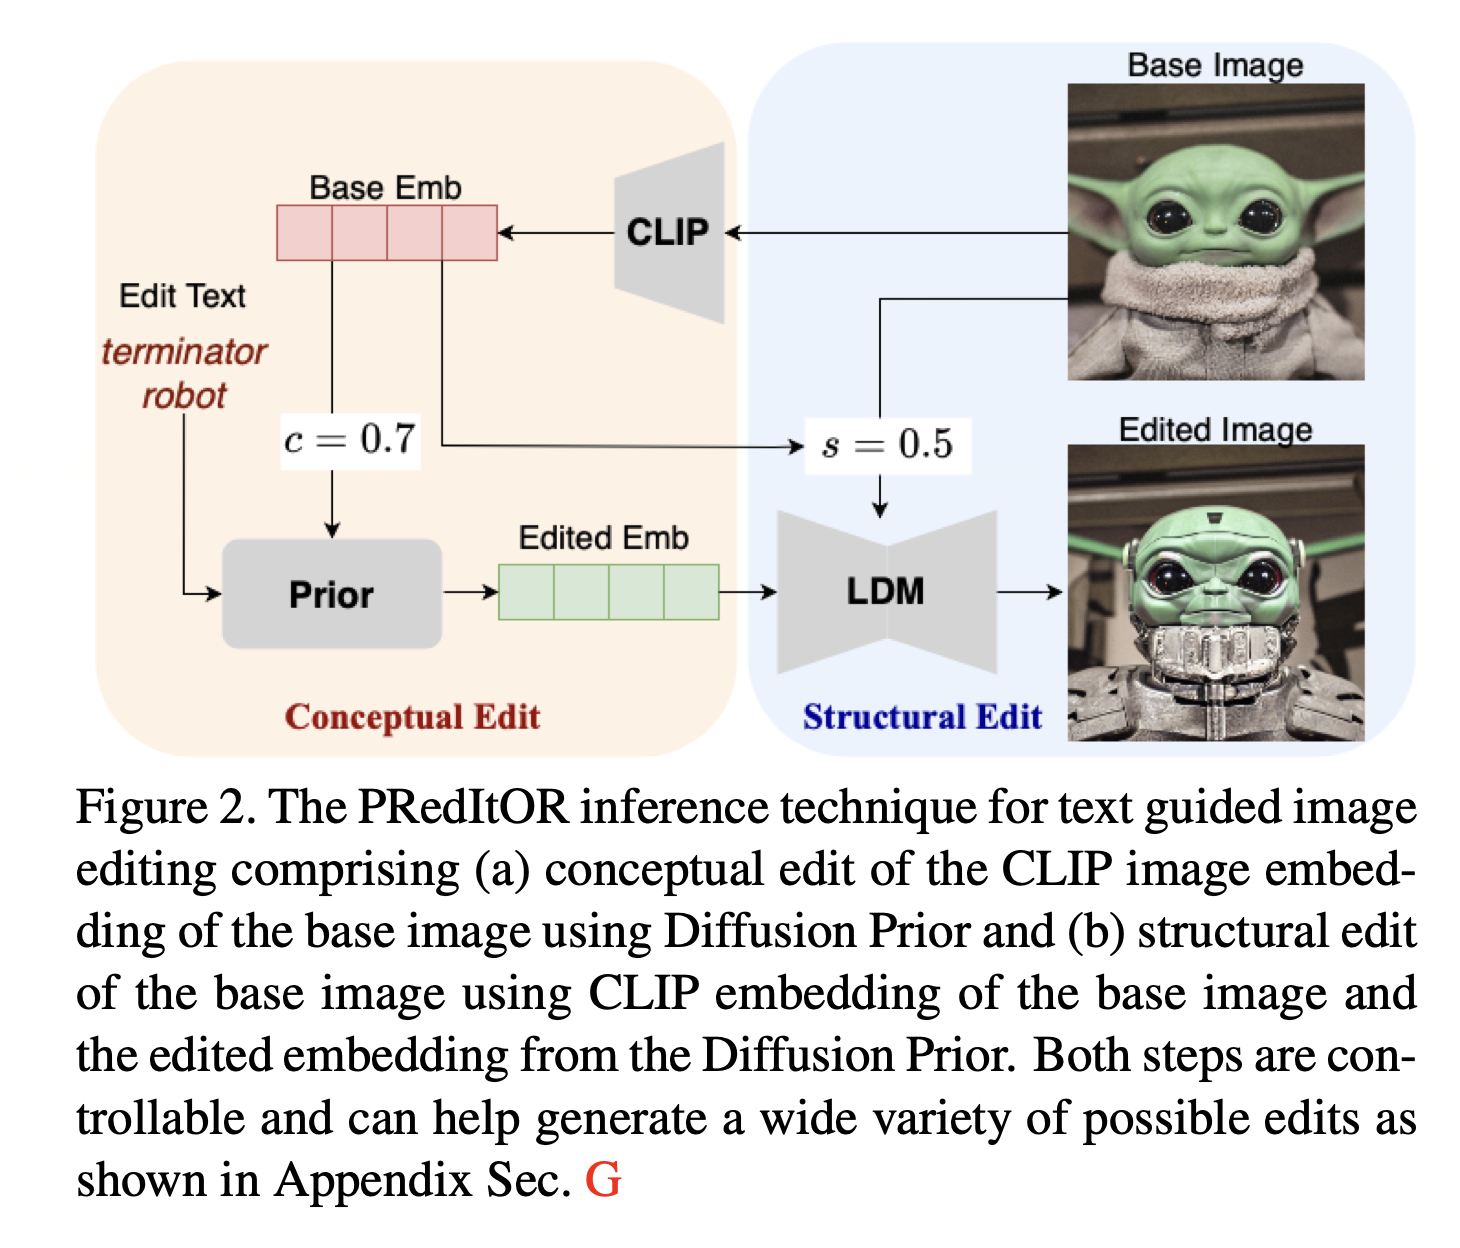

Алгоритм:
1. Conceptual edit (получение prior embedding)

    1.1. Получить CLIP image embedding для base image
    
    1.2. Получить CLIP text embedding для входного текста
    
    1.3. Для num_timsteps * c шагов выполнить denoising, где начальная точка -- эмбеддинг из п1.1 (а не N(0, 1)) и condition на п1.2
    
2. Structural edit

    2.1. Reverse DDIM
    
        2.1.1. Получить CLIP image embedding для base_image
        
        2.1.2. Получить VAE embedding для base_image
        
        2.1.3. Выполнить num_timesteps * s шагов reverse ddim для эмбеддинга из п2.1.2 с condition на п2.1.1.
        
    2.2. Decoding
    
        2.2.1. Выполнить num_timesteps * s шагов decoding'а для structural embedding'а с condition на conceptual embedding (п1)
        
        2.2.2. Получить итоговое изображение с помощью VAE Decoder

In [2]:
def l2norm(t):
    return nn.functional.normalize(t, dim=-1)


class PreditorPrior:
    """Prior network from PRedItOR paper"""
    def __init__(self, prior, c=.7):
        self.prior = prior
        self.device = prior.device
        self.image_embed_dim = prior.image_embed_dim
        self.condition_on_text_encodings = prior.condition_on_text_encodings
        self.image_embed_scale = prior.image_embed_scale
        self.num_timesteps = int(prior.noise_scheduler.num_timesteps * c)
        self.preprocess = _transform(224)

    @torch.no_grad()
    def p_sample(self, x, t, text_cond, cond_scale=1.):
        """Переопределяем метод исходного класса prior"""
        b = x.shape[0]
        model_mean, _, model_log_variance = self.prior.p_mean_variance(x=x, t=t, text_cond=text_cond, clip_denoised=True, cond_scale=cond_scale)
        noise = torch.randn_like(x)
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, batch_size, image_embed, text_cond, cond_scale=1.):
        """Переопределяем метод исходного класса prior"""
        device = self.device
        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='prior', total=self.num_timesteps):
            t = torch.full((batch_size,), i, device=device, dtype=torch.long)
            image_embed = self.p_sample(image_embed, t, text_cond, cond_scale)
        return image_embed

    @torch.no_grad()
    def sample(self, image, text, num_samples_per_batch=2, cond_scale=1.):
        """Переопределяем метод исходного класса prior"""
        text = repeat(text, 'b ... -> (b r) ...', r=num_samples_per_batch)

        batch_size = text.shape[0]
        image_embed_dim = self.image_embed_dim

        # Используем CLIP embedding как стартовую точку вместо N(0, 1)
        image = self.preprocess(image).unsqueeze(0).to(self.device)
        image_embed, _ = self.prior.clip.embed_image(image)
        image_embed = repeat(image_embed, 'b ... -> (b r) ...', r=num_samples_per_batch)

        text_embed, text_encodings, text_mask = self.prior.clip.embed_text(text)
        text_cond = dict(text_embed=text_embed)

        if self.condition_on_text_encodings:
            text_cond = {**text_cond, 'text_encodings': text_encodings, 'mask': text_mask}

        image_embeds = self.p_sample_loop(batch_size, image_embed, text_cond, cond_scale)

        # retrieve original unscaled image embed

        image_embeds /= self.image_embed_scale

        text_embeds = text_cond['text_embed']

        text_embeds = rearrange(text_embeds, '(b r) d -> b r d', r=num_samples_per_batch)
        image_embeds = rearrange(image_embeds, '(b r) d -> b r d', r=num_samples_per_batch)

        text_image_sims = einsum('b r d, b r d -> b r', l2norm(text_embeds), l2norm(image_embeds))
        top_sim_indices = text_image_sims.topk(k=1).indices

        top_sim_indices = repeat(top_sim_indices, 'b 1 -> b 1 d', d=image_embed_dim)

        top_image_embeds = image_embeds.gather(1, top_sim_indices)
        return rearrange(top_image_embeds, 'b 1 d -> b d')


class PreditorDecoder:
    def __init__(self, decoder, s, ddim_steps=50):
        self.decoder = decoder
        self.device = decoder.device
        self.unet = decoder.unets[0]
        self.vae = decoder.vaes[0]
        self.noise_scheduler = decoder.noise_schedulers[0]
        self.sample_channels = decoder.sample_channels[0]
        self.image_size = decoder.image_sizes[0]
        self.preprocess_clip = _transform(224)
        self.preprocess_vae = _transform(64)
        self.num_timesteps = int(self.noise_scheduler.num_timesteps * s)
        self.ddim_steps = ddim_steps
        self.s = s # регулирует силу structure preservation

    @torch.no_grad()
    def p_sample(self, x, t, image_embed, text_encodings, text_mask, cond_scale=1.):
        """Переопределяем метод исходного класса decoder"""
        b = x.shape[0]
        model_mean, _, model_log_variance = self.decoder.p_mean_variance(
            self.unet,
            x=x,
            t=t,
            image_embed=image_embed, # добавляем conditioning на structural embedding
            text_encodings=text_encodings,
            text_mask=text_mask,
            cond_scale=cond_scale,
            lowres_cond_img=None,
            clip_denoised=True,
            predict_x_start=False,
            noise_scheduler=self.noise_scheduler,
            learned_variance=True
        )
        noise = torch.randn_like(x)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, shape, structural_embed, image_embed, text_encodings, text_mask, cond_scale=1):
        """Переопределяем метод исходного класса decoder"""
        device = self.device
        b = shape[0]
        img = structural_embed
        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='decoder', total=self.num_timesteps):
            img = self.p_sample(
                img,
                torch.full((b,), i, device=device, dtype=torch.long),
                image_embed=image_embed,
                text_encodings=text_encodings,
                text_mask=text_mask,
                cond_scale=cond_scale
            )
        unnormalize_img = self.decoder.unnormalize_img(img)
        return unnormalize_img

    @torch.no_grad()
    def sample(self, base_image, image_embed, text_encodings, text_mask, cond_scale=5.0):
        """Переопределяем метод исходного класса decoder"""
        batch_size = image_embed.shape[0]
        shape = (batch_size, self.sample_channels, self.image_size, self.image_size)

        image_size = self.vae.get_encoded_fmap_size(self.image_size)
        shape = (batch_size, self.vae.encoded_dim, image_size, image_size)

        structural_embed = self.ddim_inverse(base_image)
        img = self.p_sample_loop(
            shape,
            structural_embed=structural_embed,
            image_embed=image_embed,
            text_encodings=text_encodings,
            text_mask=text_mask,
            cond_scale=cond_scale
        )
        img = self.vae.decode(img)
        return img

    @torch.no_grad()
    def ddim_inverse_step(self, x, e_t, t):
        next_t = t + self.num_timesteps // self.ddim_steps
        pred_x0 = self.noise_scheduler.predict_start_from_noise(x, t, e_t)
        x_next = self.noise_scheduler.q_sample(pred_x0, next_t, e_t)
        return x_next

    @torch.no_grad()
    def ddim_inverse(self, x_0):
        """Reverse ddim process"""
        clip_emb = self.decoder.clip.embed_image(self.preprocess_clip(x_0).unsqueeze(0).to(self.device))[0]
        x = self.vae.encode(self.preprocess_vae(x_0).unsqueeze(0).to(self.device))
        for t in tqdm(range(0, self.ddim_steps), desc="inverse ddim"):
            t = torch.tensor((t,), device=self.device)
            noise, _ = self.unet(x, t, image_embed=clip_emb).chunk(2, dim=1)
            x = self.ddim_inverse_step(x, noise, t)
        return x


class Preditor:
    def __init__(self, prior, decoder, c=.7, s=.5, ddim_steps=100):
        self.device = prior.device
        self.prior = PreditorPrior(prior, c)
        self.decoder = PreditorDecoder(decoder, s, ddim_steps)

    @torch.no_grad()
    def edit(self, image, text, cond_scale=5.):
        text = tokenizer.tokenize(text).to(self.device)
        base_image = Image.open(image)
        conceptual_edit = self.prior.sample(base_image, text)
        text_embed, text_encoding, text_mask = self.embed_text(text)
        image = self.decoder.sample(base_image, conceptual_edit, text_encoding, text_mask, cond_scale)
        return image.squeeze()

    @torch.no_grad()
    def embed_text(self, tokens):
        return self.decoder.decoder.clip.embed_text(tokens)

In [ ]:
# !wget https://huggingface.co/datasets/ayushtues/blipdiffusion_images/resolve/main/dog.jpg -O dog.jpg

In [291]:
preditor = Preditor(prior, decoder)

In [294]:
img = preditor.edit("dog.jpg", "with sunglasses")

prior:   0%|          | 0/700 [00:00<?, ?it/s]

inverse ddim:   0%|          | 0/100 [00:00<?, ?it/s]

decoder:   0%|          | 0/500 [00:00<?, ?it/s]

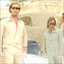

In [295]:
res = tensor_to_pil(img)
res

Промежуточные выводы:
- При больших значениях c или s получаются плохие результаты
- При больших значениях c полностью изменяется исходная картинка
- По ощущениям есть баг в PreditorPrior, буду искать